# Load data

In [196]:
# h5ad
#!aws s3 cp s3://ucsf-genomics-prod-project-data/tsuchida_doudna_collab/screenCountMatrixV2/CAS9-CAT-SCREEN-CROPv2.1-ALL-METADATA.h5ad /data2/aneuploidy/data/
    

In [197]:
# infercnv batched .txt results
#!mkdir /data2/aneuploidy/data/infercnv_results/
#!aws s3 sync s3://ucsf-genomics-prod-project-data/cas9_t-cell_aneuploidy/INFER-CNV/CAS9_SCREEN/RESULTS/ /data2/aneuploidy/data/infercnv_results/


In [16]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os

pd.options.display.max_columns = 40

# Process h5ad

In [17]:
adata = sc.read_h5ad('/groups/doudna/projects/CROPseq_05052022_Connor/Results/CART_UCSF/PROCESSED_DATA/CAS9_CAR-T/CAR-T_ALL-CELLS.h5ad')
adata

AnnData object with n_obs × n_vars = 55213 × 36601
    obs: 'batch', 'barcodes', 'sample_id', 'treatment', 'timepoint', 'donor'
    var: 'gene_ids', 'feature_types'

In [18]:
condition_x = list(adata.obs.loc[adata.obs.treatment == "intron_plusAAV_donor7_day7"].barcodes)

In [19]:
# infercnv_raw[condition_x].drop

Text(0, 0.5, 'N_Cells')

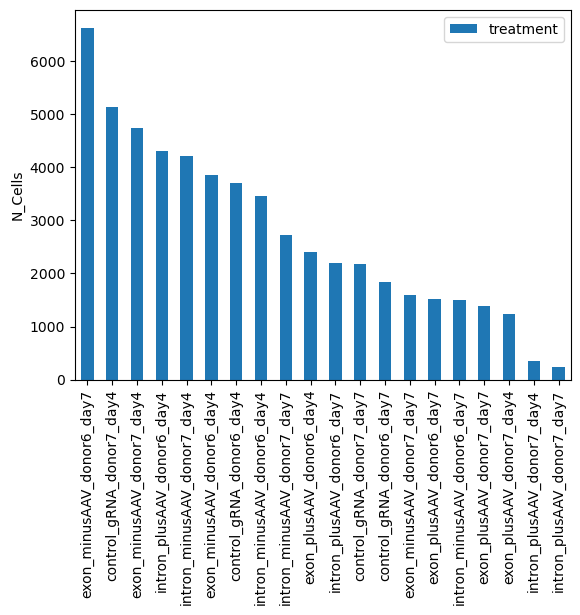

In [20]:
#### PLOT CELL NUMBERS ####
temp = pd.DataFrame(adata.obs["treatment"].value_counts())
temp.plot(kind="bar")
plt.ylabel("N_Cells")

# Read infercnv results

In [21]:
#### COLLECT INFERCNV ####

infercnv_dir = "/groups/doudna/projects/CROPseq_05052022_Connor/Results/CART_UCSF/INFER-CNV/CAS9_CAR-T/RESULTS/"
infercnv_files = [infercnv_dir+x for x in os.listdir(infercnv_dir)]

# Merge Files
infercnv_raw = pd.read_csv(infercnv_files[0], sep = '\t')
for file in infercnv_files[1:]:
    temp = pd.read_csv(file, sep = '\t')
    print(file, ": ", temp.shape[0])
    infercnv_raw = pd.concat([infercnv_raw, temp], axis=1, join="outer")

print("Num InferCNV rows:", infercnv_raw.shape[0])

# Pull Gene-Chromo Guide Annotations
gene_locs = pd.read_csv('/groups/doudna/projects/CROPseq_05052022_Connor/Results/TRAC/inferCNVgeneName.txt', sep = '\t', names = ['gene', 'chrom', 'start', 'end'])
gene_to_chrom = gene_locs.set_index('gene')['chrom']

infercnv_raw['chrom'] = infercnv_raw.index.map(gene_to_chrom)
mean_chrom_values_per_cell = infercnv_raw[infercnv_raw['chrom'].str.startswith('chr')].groupby('chrom').mean()\
        .transpose()
adata.obsm['infercnv_chrom_avg'] = mean_chrom_values_per_cell[['chr%d' % (i + 1) for i in range(22)]].reindex(adata.obs.index)

#adata.obs['target'] = 'TRAC'
#adata.obs.loc[adata.obs['guidePvalue'] > 0.05, 'target'] = np.nan
#adata.obs['target_chrom'] = adata.obs['target'].map(gene_to_chrom)

adata.obs['has_infercnv'] = ~pd.isnull(adata.obsm['infercnv_chrom_avg']).any(axis = 1)
#adata.obs['lost_chroms'] = (adata.obsm['infercnv_chrom_avg'] <= 0.95).apply(lambda cell_mask: \
#        set(cell_mask.index[cell_mask]), axis = 1)
adata.obs.loc[~adata.obs['has_infercnv'], 'lost_chroms'] = np.nan

adata.obs.head()


/groups/doudna/projects/CROPseq_05052022_Connor/Results/CART_UCSF/INFER-CNV/CAS9_CAR-T/RESULTS/inferCNV_results_CAR-T_Donor6_Day7.txt :  2032
/groups/doudna/projects/CROPseq_05052022_Connor/Results/CART_UCSF/INFER-CNV/CAS9_CAR-T/RESULTS/inferCNV_results_CAR-T_Donor6_Day4.txt :  2357
/groups/doudna/projects/CROPseq_05052022_Connor/Results/CART_UCSF/INFER-CNV/CAS9_CAR-T/RESULTS/inferCNV_results_CAR-T_Donor7_Day4.txt :  2066
Num InferCNV rows: 2498


,batch,barcodes,sample_id,treatment,timepoint,donor,has_infercnv,lost_chroms
AAACCCACAGCGAGTA-1,1,AAACCCACAGCGAGTA-1,well-1_control_gRNA_donor6,control_gRNA_donor6_day4,day4,donor6,True,NaN
AAACCCAGTAGGATAT-1,1,AAACCCAGTAGGATAT-1,well-1_control_gRNA_donor6,control_gRNA_donor6_day4,day4,donor6,True,NaN
AAACCCAGTCCGACGT-1,1,AAACCCAGTCCGACGT-1,well-1_control_gRNA_donor6,control_gRNA_donor6_day4,day4,donor6,True,NaN
AAACGAATCACACGAT-1,1,AAACGAATCACACGAT-1,well-1_control_gRNA_donor6,control_gRNA_donor6_day4,day4,donor6,True,NaN
AAACGAATCTGCGGGT-1,1,AAACGAATCTGCGGGT-1,well-1_control_gRNA_donor6,control_gRNA_donor6_day4,day4,donor6,True,NaN


In [22]:
#### FIND BREAKPOINTS ####
for chrom in sorted(list(set(infercnv_raw['chrom']))): # ["chr14"]
    print(chrom)
    if chrom[0] != "c":
        continue
        
    locs = pd.Series(infercnv_raw.loc[infercnv_raw['chrom'] == chrom,:].index)
    locs = locs.apply(lambda x: gene_locs.loc[gene_locs['gene'] == x, "start"].values[0])
    order = np.argsort(locs)
    vals = infercnv_raw.loc[infercnv_raw['chrom'] == chrom, adata[adata.obs['has_infercnv']].obs.index]
    locs = locs[order].to_numpy()
    vals = vals.iloc[order,:].to_numpy()
    vals_binary = (vals > 0.95).astype(int)
    
    left_binary = np.cumsum(vals_binary, axis = 0)[:-1]
    left_binary_den = (np.array(list(range(vals_binary.shape[0] - 1))) + 1)[:,None]
    left_binary = left_binary/left_binary_den
    right_binary = np.cumsum(vals_binary[::-1], axis = 0)[:-1][::-1]
    right_binary_den = (np.array(list(range(vals_binary.shape[0] - 1))) + 1)[:,None][::-1]
    right_binary = right_binary/right_binary_den
    breakpoints = np.argmax(np.abs(left_binary - right_binary), axis = 0)
    
    left_binary_avg = left_binary[breakpoints, range(len(breakpoints))]
    right_binary_avg = right_binary[breakpoints, range(len(breakpoints))]
    
    left = np.cumsum(vals, axis = 0)[:-1]
    left_den = (np.array(list(range(vals.shape[0] - 1))) + 1)[:,None]
    left = left/left_den
    right = np.cumsum(vals[::-1], axis = 0)[:-1][::-1]
    right_den = (np.array(list(range(vals.shape[0] - 1))) + 1)[:,None][::-1]
    right = right/right_den
    
    left_avg = left[breakpoints, range(len(breakpoints))]
    right_avg = right[breakpoints, range(len(breakpoints))]
    
    locs = np.tile(locs, (len(breakpoints), 1))
    locs1 = locs[range(len(breakpoints)), breakpoints]
    locs2 = locs[range(len(breakpoints)), breakpoints + 1]
    
    breakpoint_locs = np.mean(np.vstack([locs1, locs2]), axis = 0)
    
    #print(len(locs))
    #print(vals_binary.shape)
    
    adata.obs.loc[adata.obs['has_infercnv'], chrom + "_bp_loc"] = breakpoint_locs
    adata.obs.loc[adata.obs['has_infercnv'], chrom + "_bp_n"] = breakpoints
    adata.obs.loc[adata.obs['has_infercnv'], chrom + "_left"] = left_avg
    adata.obs.loc[adata.obs['has_infercnv'], chrom + "_right"] = right_avg
    adata.obs.loc[adata.obs['has_infercnv'], chrom + "_left_binary"] = left_binary_avg
    adata.obs.loc[adata.obs['has_infercnv'], chrom + "_right_binary"] = right_binary_avg
    adata.obs.loc[adata.obs['has_infercnv'], chrom + "_left_n"] = breakpoints + 1
    adata.obs.loc[adata.obs['has_infercnv'], chrom + "_right_n"] = vals.shape[0] - (breakpoints + 1)
    adata.obs.loc[adata.obs['has_infercnv'], chrom + "_binary"] = np.mean(vals_binary, axis = 0)
    
"""
# Clean Columns
cols = adata.obs.columns[adata.obs.columns.str.contains("bp") | adata.obs.columns.str.contains("right") |
                 adata.obs.columns.str.contains("left") | adata.obs.columns.str.contains("binary") |
                 adata.obs.columns.str.contains("event")       ]
#adata.obs.loc[:,cols].to_csv("/groups/doudna/projects/CROPseq_05052022_Connor/Results/CART_UCSF/CART_UCSF_aneuploidy_breakpoints.csv")

"""
#adata.obs.to_csv("/groups/doudna/projects/CROPseq_05052022_Connor/Results/CART_UCSF/CART_UCSF_aneuploidy_breakpoints.csv")


GL000219.1
chr1
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr2
chr20
chr21
chr22
chr3
chr4
chr5
chr6
chr7
chr8
chr9


'\n# Clean Columns\ncols = adata.obs.columns[adata.obs.columns.str.contains("bp") | adata.obs.columns.str.contains("right") |\n                 adata.obs.columns.str.contains("left") | adata.obs.columns.str.contains("binary") |\n                 adata.obs.columns.str.contains("event")       ]\n#adata.obs.loc[:,cols].to_csv("/groups/doudna/projects/CROPseq_05052022_Connor/Results/CART_UCSF/CART_UCSF_aneuploidy_breakpoints.csv")\n\n'

In [328]:
adata.obs.head()

,batch,barcodes,sample_id,treatment,timepoint,donor,has_infercnv,lost_chroms,chr1_bp_loc,chr1_bp_n,chr1_left,chr1_right,chr1_left_binary,chr1_right_binary,chr1_left_n,chr1_right_n,chr1_binary,chr10_bp_loc,chr10_bp_n,chr10_left,...,chr7_right_n,chr7_binary,chr8_bp_loc,chr8_bp_n,chr8_left,chr8_right,chr8_left_binary,chr8_right_binary,chr8_left_n,chr8_right_n,chr8_binary,chr9_bp_loc,chr9_bp_n,chr9_left,chr9_right,chr9_left_binary,chr9_right_binary,chr9_left_n,chr9_right_n,chr9_binary
AAACCCACAGCGAGTA-1,1,AAACCCACAGCGAGTA-1,well-1_control_gRNA_donor6,control_gRNA_donor6_day4,day4,donor6,True,NaN,229883388.5,248.0,NaN,NaN,0.935743,0.8,249.0,10.0,0.930502,110719743.0,97.0,NaN,...,83.0,0.672566,117991972.5,73.0,NaN,NaN,0.959459,0.000000,74.0,22.0,0.739583,136855421.5,91.0,NaN,NaN,0.967391,0.666667,92.0,3.0,0.957895
AAACCCAGTAGGATAT-1,1,AAACCCAGTAGGATAT-1,well-1_control_gRNA_donor6,control_gRNA_donor6_day4,day4,donor6,True,NaN,229883388.5,248.0,NaN,NaN,0.935743,0.8,249.0,10.0,0.930502,96323912.5,83.0,NaN,...,110.0,0.929204,42160551.5,23.0,NaN,NaN,0.000000,0.930556,24.0,72.0,0.697917,33869426.5,18.0,0.924076,NaN,0.000000,0.947368,19.0,76.0,0.757895
AAACCCAGTCCGACGT-1,1,AAACCCAGTCCGACGT-1,well-1_control_gRNA_donor6,control_gRNA_donor6_day4,day4,donor6,True,NaN,229883388.5,248.0,NaN,NaN,0.935743,0.8,249.0,10.0,0.930502,6869521.5,8.0,0.939518,...,110.0,0.929204,141769069.0,92.0,NaN,NaN,0.946237,0.666667,93.0,3.0,0.937500,136855421.5,91.0,NaN,NaN,0.967391,0.666667,92.0,3.0,0.957895
AAACGAATCACACGAT-1,1,AAACGAATCACACGAT-1,well-1_control_gRNA_donor6,control_gRNA_donor6_day4,day4,donor6,True,NaN,229883388.5,248.0,NaN,NaN,0.935743,0.8,249.0,10.0,0.930502,96323912.5,83.0,NaN,...,64.0,0.805310,23970393.5,7.0,0.93935,NaN,0.000000,0.931818,8.0,88.0,0.854167,136855421.5,91.0,NaN,NaN,0.967391,0.666667,92.0,3.0,0.957895
AAACGAATCTGCGGGT-1,1,AAACGAATCTGCGGGT-1,well-1_control_gRNA_donor6,control_gRNA_donor6_day4,day4,donor6,True,NaN,227221675.5,246.0,NaN,NaN,0.935223,0.0,247.0,12.0,0.891892,96323912.5,83.0,NaN,...,110.0,0.929204,141769069.0,92.0,NaN,NaN,0.946237,0.666667,93.0,3.0,0.937500,136855421.5,91.0,NaN,NaN,0.967391,0.666667,92.0,3.0,0.957895


In [ ]:
def to_compact_chrom_loss_status(chrom_loss_status):
    if chrom_loss_status in {'no_loss', 'multiple_loss'}:
        return chrom_loss_status
    elif chrom_loss_status.startswith('chr'):
        return 'single_loss'
    else:
        raise ValueError(chrom_loss_status)
        
filtered_adata.obs['compact_chrom_loss_status'] = filtered_adata.obs['chrom_loss_status'].apply(\
        to_compact_chrom_loss_status)
display(filtered_adata.obs['compact_chrom_loss_status'].value_counts())

/tmp/ipykernel_20931/4167528629.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gg['%s_event' % chrom] = event
/tmp/ipykernel_20931/4167528629.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gg['%s_event' % chrom] = event
/tmp/ipykernel_20931/4167528629.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

/tmp/ipykernel_20931/4167528629.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gg['%s_event' % chrom] = event
/tmp/ipykernel_20931/4167528629.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gg['%s_event' % chrom] = event
/tmp/ipykernel_20931/4167528629.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

/tmp/ipykernel_20931/4167528629.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gg['%s_event' % chrom] = event
/tmp/ipykernel_20931/4167528629.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gg['%s_event' % chrom] = event
/tmp/ipykernel_20931/4167528629.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

/tmp/ipykernel_20931/4167528629.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gg['%s_event' % chrom] = event
/tmp/ipykernel_20931/4167528629.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gg['%s_event' % chrom] = event
/tmp/ipykernel_20931/4167528629.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

/tmp/ipykernel_20931/4167528629.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gg['%s_event' % chrom] = event
/tmp/ipykernel_20931/4167528629.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gg['%s_event' % chrom] = event
/tmp/ipykernel_20931/4167528629.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

/tmp/ipykernel_20931/4167528629.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gg['%s_event' % chrom] = event
/tmp/ipykernel_20931/4167528629.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gg['%s_event' % chrom] = event
/tmp/ipykernel_20931/4167528629.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

/tmp/ipykernel_20931/4167528629.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gg['%s_event' % chrom] = event
/tmp/ipykernel_20931/4167528629.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gg['%s_event' % chrom] = event
/tmp/ipykernel_20931/4167528629.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

/tmp/ipykernel_20931/4167528629.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gg['%s_event' % chrom] = event
/tmp/ipykernel_20931/4167528629.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gg['%s_event' % chrom] = event
/tmp/ipykernel_20931/4167528629.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

/tmp/ipykernel_20931/4167528629.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gg['%s_event' % chrom] = event
/tmp/ipykernel_20931/4167528629.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gg['%s_event' % chrom] = event
/tmp/ipykernel_20931/4167528629.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

/tmp/ipykernel_20931/4167528629.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gg['%s_event' % chrom] = event
/tmp/ipykernel_20931/4167528629.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gg['%s_event' % chrom] = event
/tmp/ipykernel_20931/4167528629.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

'\ndfs = []\ntypes = ["no_loss", "lost_partial", "lost_all"]\nfor chrom in (\'chr%d\' % i for i in range(1, 23)):\n    temp_series = aneuploidy_events[f"{chrom}_event"].value_counts()\n    temp_df = pd.DataFrame(temp_series).T\n    cols = temp_df.columns\n    missing_cols = [x for x in types if x not in cols]\n    for miss in missing_cols:\n        temp_df[miss] = 0\n    #temp_df.columns = [f"{chrom}_{x}" for x in temp_df.columns]\n    dfs.append(temp_df)\n    \ncart_summary = pd.concat(dfs)\ncart_summary.to_excel("CART_UCSF_aneuploidy_event_counts.xlsx")\n'

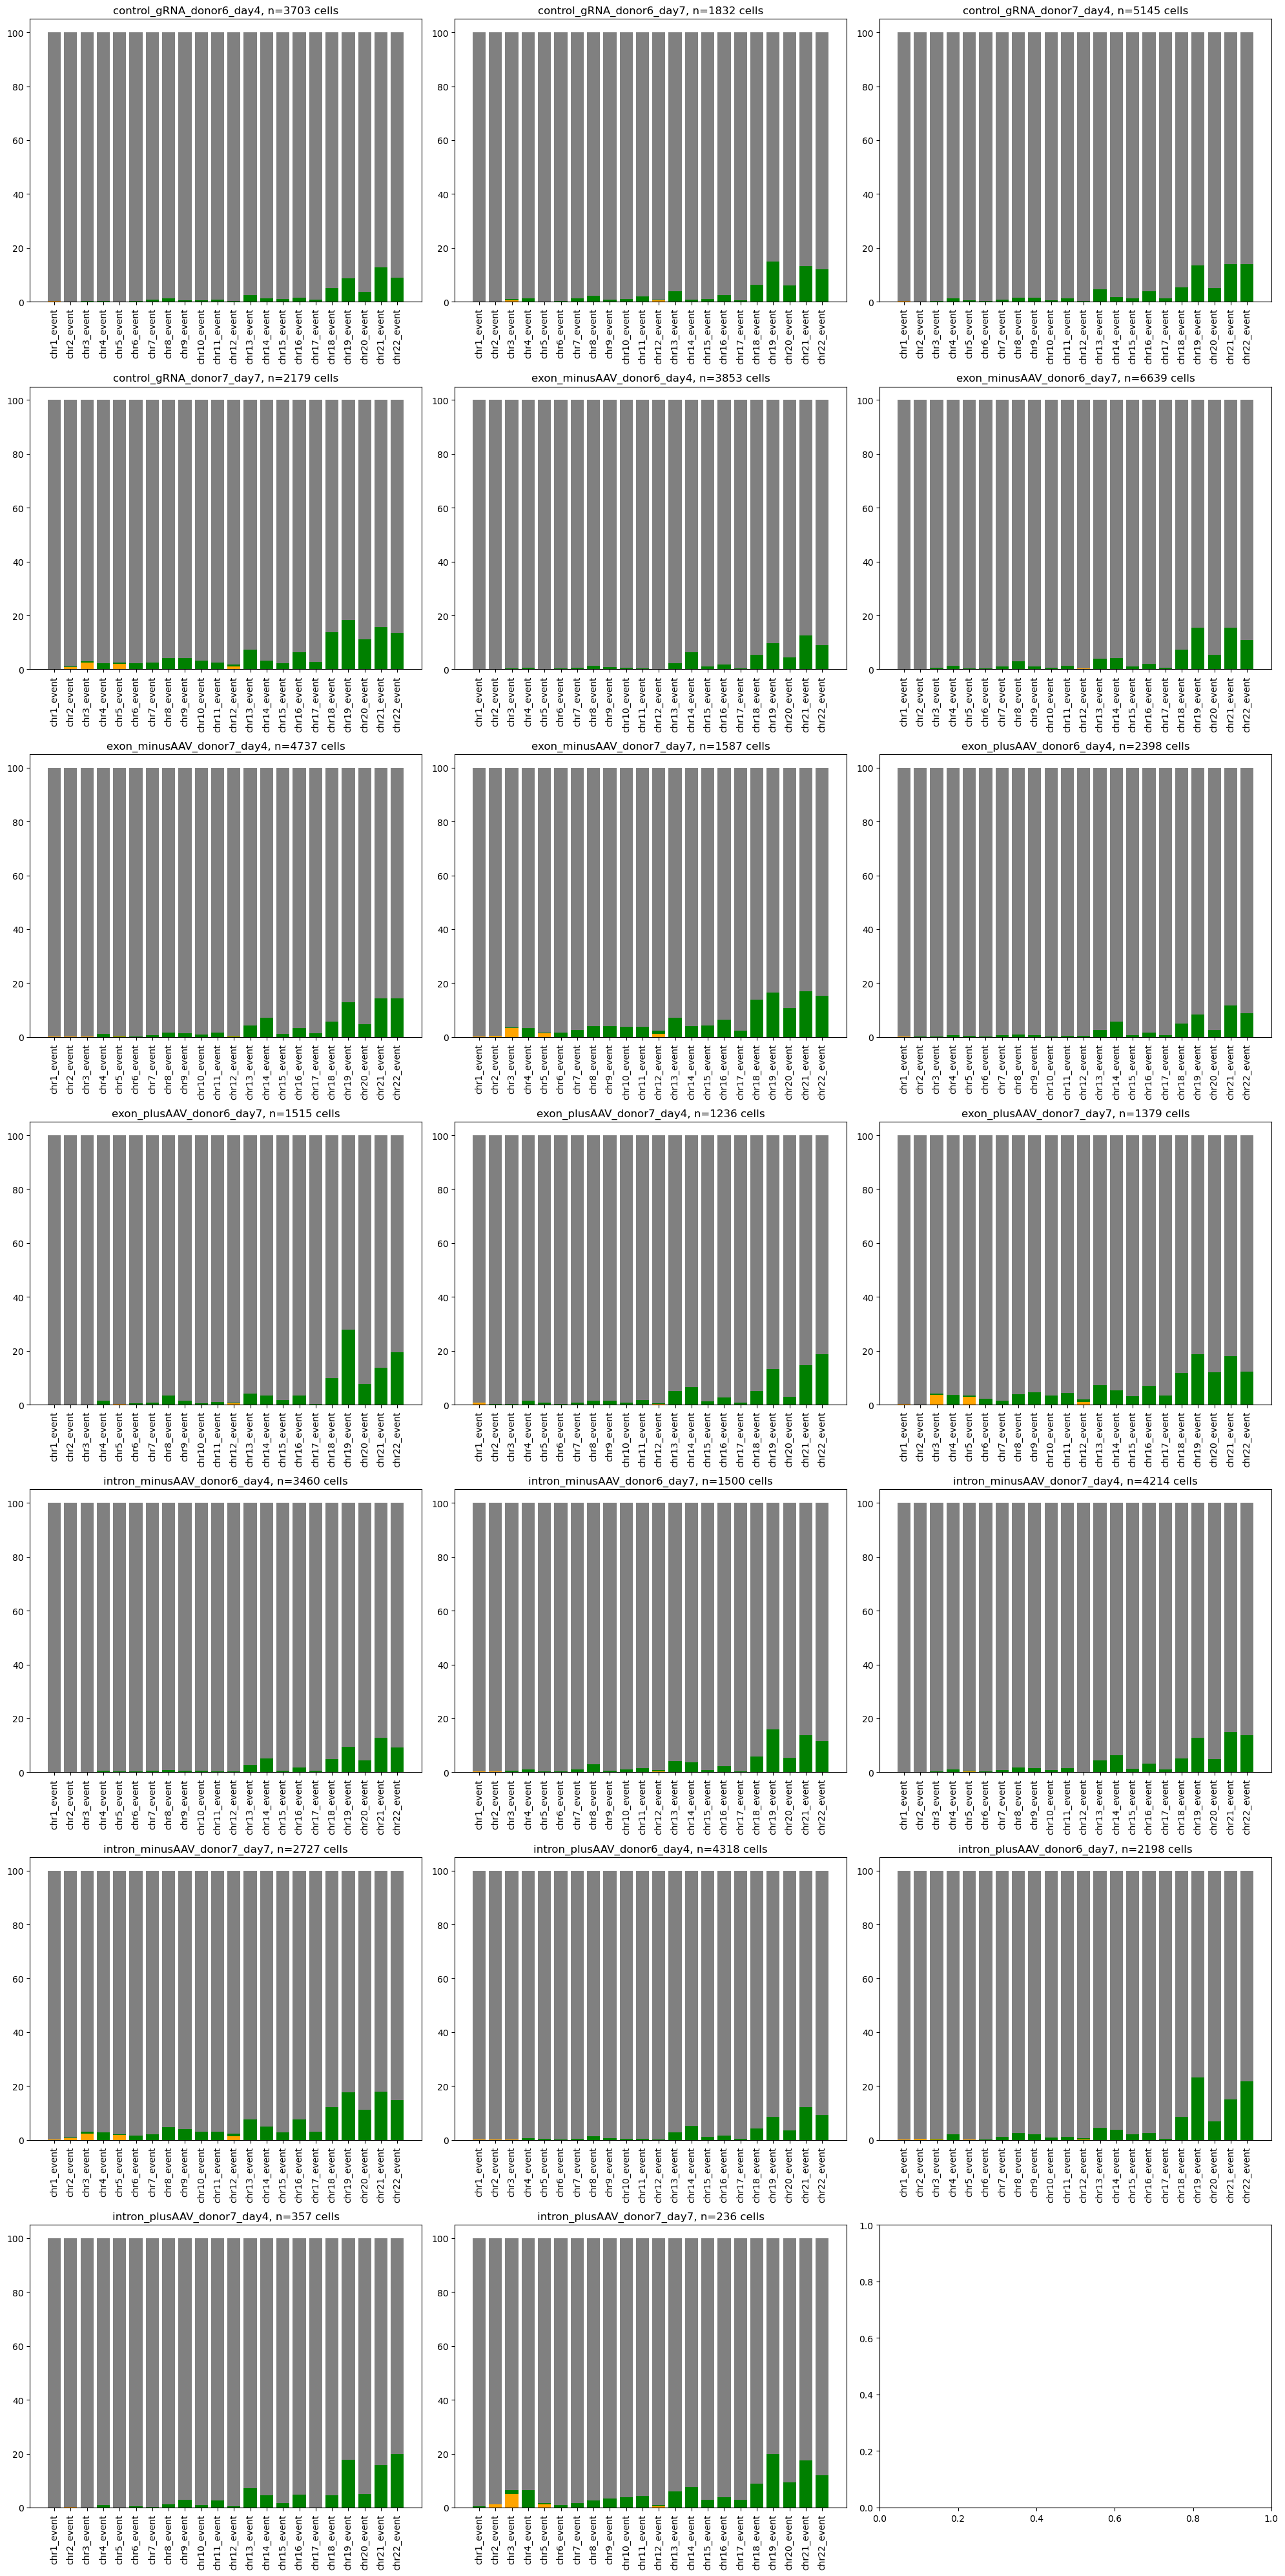

In [181]:
#### TABULATE EVENTS PER TREATMENT #### 
LOSS_FRAC = 0.7
MIN_GENES = 150 #40 #90

aneuploidy_events = pd.read_csv("/groups/doudna/projects/CROPseq_05052022_Connor/Results/CART_UCSF/CART_UCSF_aneuploidy_breakpoints.csv", 
                                index_col = 0)

n_cols = 3
n_rows = int(np.ceil(20/n_cols))
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, clear=True, figsize = (20,40))
axes = ax.ravel()

grouped = aneuploidy_events.groupby(["treatment"])

types = ["no_loss", "lost_partial", "lost_all"]
treatment_dfs = {}
i = 0
for g in list(grouped.groups):
    gg = grouped.get_group(g)
    dfs = []
    
    for chrom in ('chr%d' % i for i in range(1, 23)):
        ## TABULATE LOSS TYPES
        left_binary = gg['%s_left_binary' % chrom]
        left_n = gg['%s_left_n' % chrom]
        right_binary = gg['%s_right_binary' % chrom]
        right_n = gg['%s_right_n' % chrom]
        total_binary = (left_n * left_binary + right_n * right_binary) / (left_n + right_n)

        lost_all = (total_binary <= 1 - LOSS_FRAC)
        lost_left = (left_binary <= 1 - LOSS_FRAC)
        lost_right = (right_binary <= 1 - LOSS_FRAC)
        lost_only_left = lost_left & (~lost_right)
        lost_only_right = lost_right & (~lost_left)
        enough_genes_left = (left_n >= MIN_GENES)
        enough_genes_right = (right_n >= MIN_GENES)
        lost_partial = (lost_only_left & enough_genes_left) | (lost_only_right & enough_genes_right)

        event = np.where(lost_partial, 'lost_partial', np.where(lost_all, 'lost_all', 'no_loss'))
        gg['%s_event' % chrom] = event
        
        # COUNT
        temp_series = gg[f"{chrom}_event"].value_counts()
        temp_df = pd.DataFrame(temp_series).T
        cols = temp_df.columns
        missing_cols = [x for x in types if x not in cols]
        for miss in missing_cols:
            temp_df[miss] = 0
        #temp_df.columns = [f"{chrom}_{x}" for x in temp_df.columns]
        dfs.append(temp_df)
    treatment_df = pd.concat(dfs)
    treatment_dfs[g] = treatment_df
    
    # PLOT
    xs = np.arange(1,23)
    labels = treatment_df.index
    no = list(treatment_df.no_loss)
    all_loss = list(treatment_df.lost_all)
    partial = list(treatment_df.lost_partial)
    total = treatment_df.iloc[0].sum() #np.sum(no) + np.sum(lost_all) + np.sum(partial)

    axes[i].bar(xs, partial/total*100, color = "orange")
    axes[i].bar(xs, all_loss/total*100, bottom = partial/total*100, color = "green")
    axes[i].bar(xs, no/total*100, bottom = partial/total*100 + all_loss/total*100, color = "grey")
    axes[i].set_xticks(xs)
    axes[i].set_xticklabels(labels, rotation = 90)
    axes[i].set_title(f"{g}, n={total} cells")
    
    i+= 1
    
final_df = pd.concat(treatment_dfs)
#final_df.to_excel("CART_UCSF_Aneuploidy_Events_AllChromo.xlsx")

plt.tight_layout()
#plt.savefig("CART_Loss.png")
"""
dfs = []
types = ["no_loss", "lost_partial", "lost_all"]
for chrom in ('chr%d' % i for i in range(1, 23)):
    temp_series = aneuploidy_events[f"{chrom}_event"].value_counts()
    temp_df = pd.DataFrame(temp_series).T
    cols = temp_df.columns
    missing_cols = [x for x in types if x not in cols]
    for miss in missing_cols:
        temp_df[miss] = 0
    #temp_df.columns = [f"{chrom}_{x}" for x in temp_df.columns]
    dfs.append(temp_df)
    
cart_summary = pd.concat(dfs)
cart_summary.to_excel("CART_UCSF_aneuploidy_event_counts.xlsx")
"""

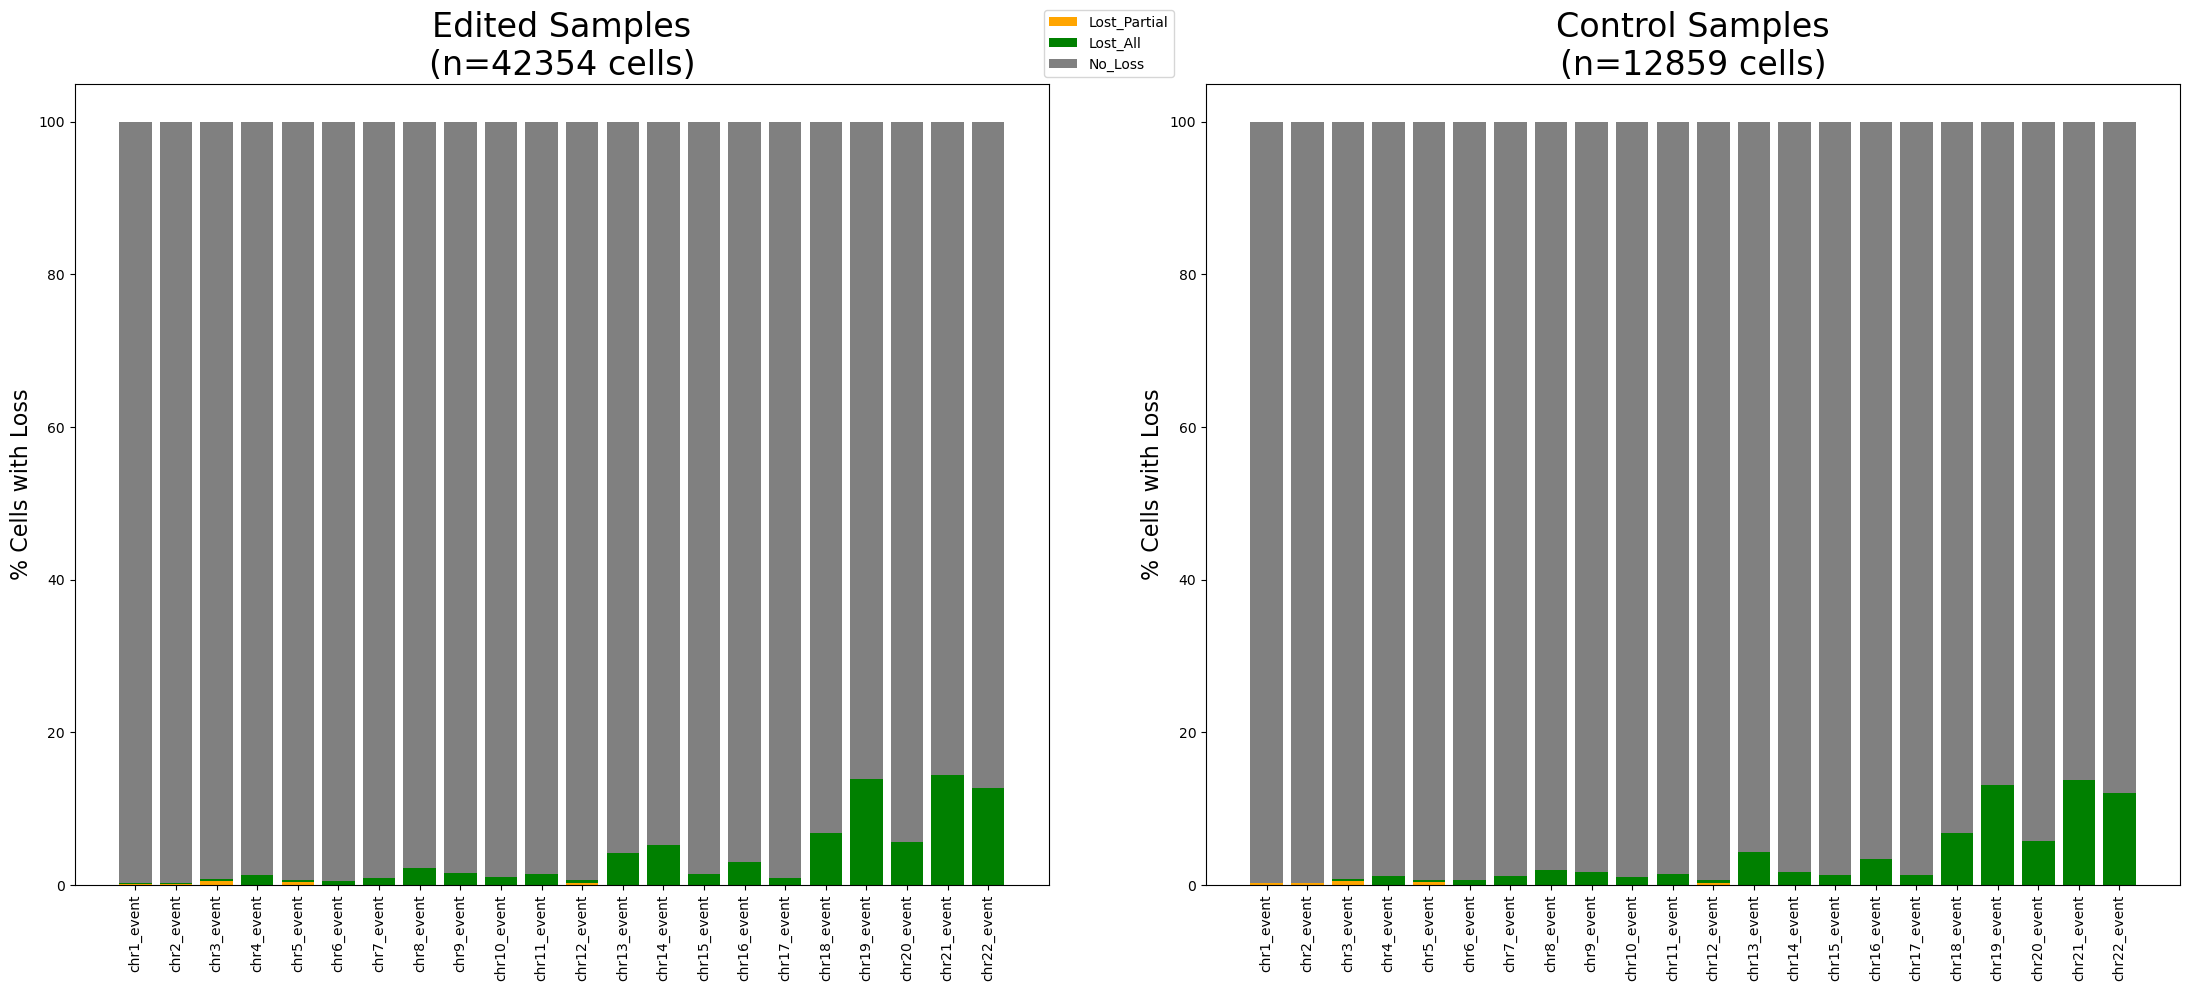

In [182]:
#### TABULATE ANEUPLOIDY #####
ctrl_df = pd.concat([v for k,v in treatment_dfs.items() if "control" in k], axis = 1)
edited_df = pd.concat([v for k,v in treatment_dfs.items() if "control" not in k], axis = 1)

labels = edited_df[["no_loss"]].sum(axis = 1).index
xs = np.arange(1, 23)

no_loss_e = list(edited_df[["no_loss"]].sum(axis = 1))
lost_all_e = list(edited_df[["lost_all"]].sum(axis = 1))
lost_partial_e = list(edited_df[["lost_partial"]].sum(axis = 1))
total_e = edited_df.iloc[0].sum()

no_loss_ctrl = list(ctrl_df[["no_loss"]].sum(axis = 1))
lost_all_ctrl = list(ctrl_df[["lost_all"]].sum(axis = 1))
lost_partial_ctrl = list(ctrl_df[["lost_partial"]].sum(axis = 1))
total_c = ctrl_df.iloc[0].sum()

n_cols = 2
n_rows = 1
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, clear=True, figsize = (22,10))
axes = ax.ravel()

axes[0].bar(xs, lost_partial_e/total_e*100, color = "orange")
axes[0].bar(xs, lost_all_e/total_e*100, bottom = lost_partial_e/total_e*100, color = "green")
axes[0].bar(xs, no_loss_e/total_e*100, bottom = lost_partial_e/total_e*100 + lost_all_e/total_e*100, color = "grey")
axes[0].set_xticks(xs)
axes[0].set_xticklabels(labels, rotation = 90)
axes[0].set_ylabel("% Cells with Loss", size = 16)
axes[0].set_title(f"Edited Samples\n(n={total_e} cells)", size =24)

axes[1].bar(xs, lost_partial_ctrl/total_c*100, color = "orange", label = "Lost_Partial")
axes[1].bar(xs, lost_all_ctrl/total_c*100, bottom = lost_partial_ctrl/total_c*100, color = "g", label = "Lost_All")
axes[1].bar(xs, no_loss_ctrl/total_c*100, bottom = lost_partial_ctrl/total_c*100 + lost_all_ctrl/total_c*100, 
            color = "grey", label = "No_Loss")
axes[1].set_xticks(xs)
axes[1].set_xticklabels(labels, rotation = 90)
axes[1].set_ylabel("% Cells with Loss", size = 16)
axes[1].set_title(f"Control Samples\n(n={total_c} cells)", size =24)

plt.legend(loc='center',  bbox_to_anchor=(-0.1, 1.05))
plt.tight_layout()
#plt.savefig("Aggregated_CART_loss_v40GenesForPartialLoss.png")


/tmp/ipykernel_20931/1257848827.py:3: RuntimeWarning: invalid value encountered in true_divide
  partial_ratios = partial_ratios = [x if str(x) != "nan" else 0 for x in(lost_partial_e/total_e*100)/(lost_partial_ctrl/total_c*100)]


Lost Partial: [0.8015242952259527, 0.9487740237049628, 0.8978113047173821, 0, 0.9424488635469298, 0, 0, 0, 0, 0, 0, 0.9529907971436516, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] Chr14: 0
Lost All: [0.56384285 0.71761817 1.12020767 1.18302306 0.86288501 0.75325452
 0.84881868 1.12129214 0.93106358 1.03791465 0.96795354 0.98849015
 0.95870385 3.014487   1.10520603 0.87436209 0.74889896 1.00472235
 1.0569646  0.97015341 1.04206657 1.04854201] Chr14: 3.0144869958497953
No Losss: [0.01000625 0.01000338 0.01000287 0.00997913 0.01000624 0.01001525
 0.01001688 0.00997585 0.01001144 0.00999616 0.0100047  0.01000171
 0.01001873 0.00964124 0.00998641 0.01004378 0.01003264 0.00999656
 0.00991386 0.01001828 0.00993277 0.00993337] Chr14: 0.009641238266529838


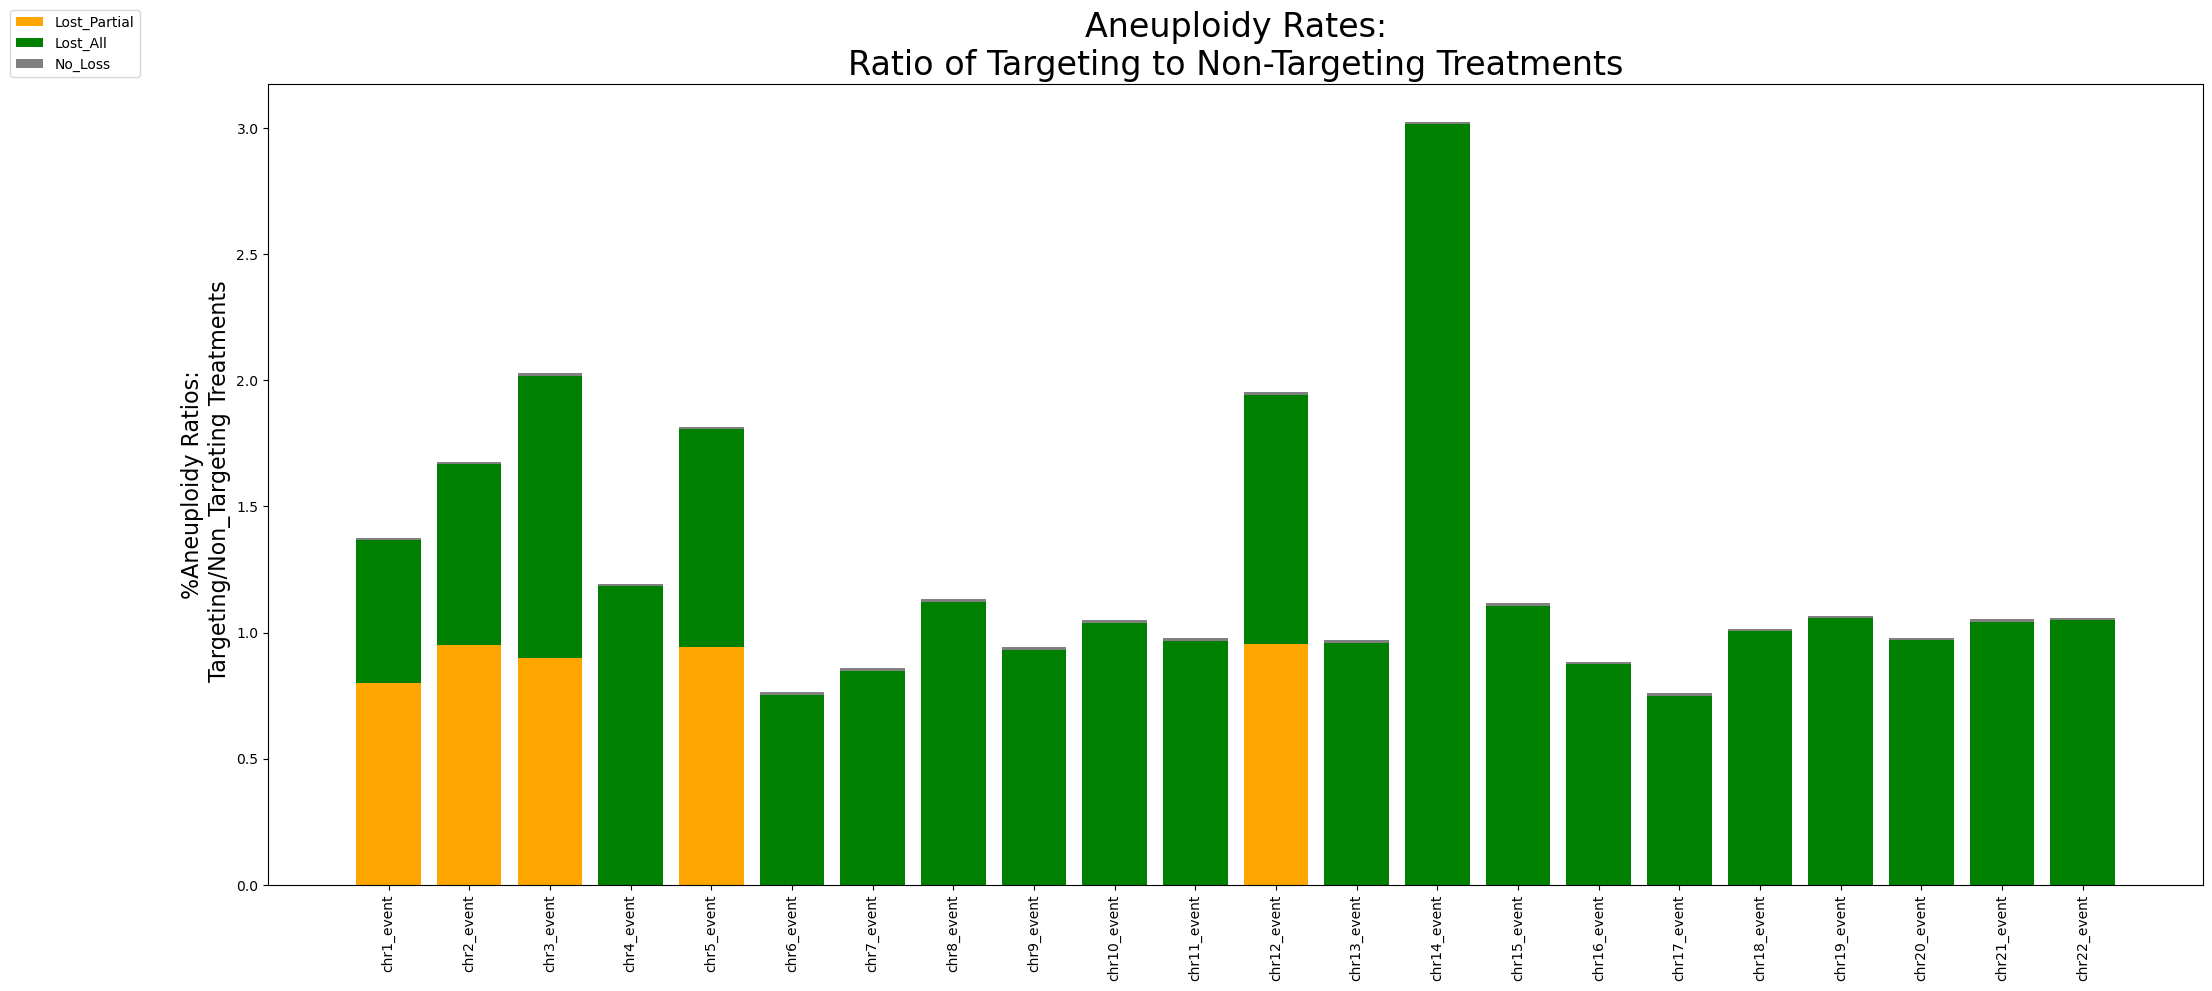

In [199]:
#### PLOT RATIOS ####

partial_ratios = partial_ratios = [x if str(x) != "nan" else 0 for x in(lost_partial_e/total_e*100)/(lost_partial_ctrl/total_c*100)]
all_ratios = (lost_all_e/total_e*100)/(lost_all_ctrl/total_c*100)
no_ratios = (no_loss_e/total_e)/(no_loss_ctrl/total_c*100)
print("Lost Partial:", partial_ratios, f"Chr14: {partial_ratios[13]}")
print("Lost All:", all_ratios, f"Chr14: {all_ratios[13]}")
print("No Losss:", no_ratios, f"Chr14: {no_ratios[13]}")

n_cols = 1
n_rows = 1
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, clear=True, figsize = (22,10))

ax.bar(xs, partial_ratios, color = "orange", label = "Lost_Partial")
ax.bar(xs, all_ratios, color = "g", label = "Lost_All", bottom = partial_ratios)
ax.bar(xs, no_ratios, bottom = all_ratios+partial_ratios, 
            color = "grey", label = "No_Loss")

ax.set_xticks(xs)
ax.set_xticklabels(labels, rotation = 90)
ax.set_ylabel(f"%Aneuploidy Ratios:\n Targeting/Non_Targeting Treatments", size = 16)
ax.set_title(f"Aneuploidy Rates:\nRatio of Targeting to Non-Targeting Treatments", size =24)

plt.legend(loc='center',  bbox_to_anchor=(-0.1, 1.05))
plt.tight_layout()

plt.savefig("Aneuploidy_Percents_Relative_to_Control.png")

In [272]:
#### Ratios: NO BIN ANALYSIS
rows = []

for k,v in treatment_dfs.items():
    temp_df = v
    temp_df["Treatment"] = k
    temp_df["PctChr14_AllLossTypes"] = 100*(temp_df["lost_all"]+temp_df["lost_partial"])/(temp_df["lost_all"]+temp_df["lost_partial"]+temp_df.no_loss)
    row = temp_df.loc[temp_df.index == "chr14_event"]
    rows.append(row)

chr14_df = pd.concat(rows)
chr14_df["Day"] = chr14_df["Treatment"].apply(lambda x: int(x[-1]))
chr14_df["Donor"] = chr14_df["Treatment"].apply(lambda x: x.split("_")[-2])
chr14_df["HDR_Type"] = chr14_df["Treatment"].apply(lambda x: x.split("_")[-3])
chr14_df["Guide"] = chr14_df["Treatment"].apply(lambda x: x.split("_")[0])

ratio_rows = []
for row in chr14_df.itertuples():
    treatment = row.Treatment
    guide = row.Guide
    if guide == "control":
        continue
    pct_loss = row.PctChr14_AllLossTypes
    day = row.Day
    donor = row.Donor
    hdr = row.HDR_Type
    
    # Control
    ctrl = chr14_df.loc[(chr14_df.Day == day) & \
                        (chr14_df.Donor == donor) & \
                        (chr14_df.Guide == "control")]
    ctrl_pct = float(100*(ctrl.lost_partial+ctrl.lost_all)/(ctrl.lost_partial+ctrl.lost_all+ctrl.no_loss))
    ctrl_name = "control_gRNA_"+donor+"_day"+str(day)
    
    # Ratio
    ratio = float(row.PctChr14_AllLossTypes)/float(ctrl_pct)
    
    row = [treatment, pct_loss, day, donor, hdr, ctrl_name, ctrl_pct, ratio]
    ratio_rows.append(row)
    
ratio_df = pd.DataFrame(ratio_rows, columns= ["Treatment", "Treatment_Loss", "Day", "Donor", "HDR_Type",
                                              "Control_Sample", "Control_Loss", "Loss_Ratio_To_Control"])
ratio_df.head(20)

,Treatment,Treatment_Loss,Day,Donor,HDR_Type,Control_Sample,Control_Loss,Loss_Ratio_To_Control
0,exon_minusAAV_donor6_day4,6.306774,4,donor6,minusAAV,control_gRNA_donor6_day4,1.296246,4.865413
1,exon_minusAAV_donor6_day7,4.172315,7,donor6,minusAAV,control_gRNA_donor6_day7,0.818777,5.095788
2,exon_minusAAV_donor7_day4,7.093097,4,donor7,minusAAV,control_gRNA_donor7_day4,1.807580,3.924084
3,exon_minusAAV_donor7_day7,4.095778,7,donor7,minusAAV,control_gRNA_donor7_day7,3.166590,1.293435
4,exon_plusAAV_donor6_day4,5.713094,4,donor6,plusAAV,control_gRNA_donor6_day4,1.296246,4.407414
5,exon_plusAAV_donor6_day7,3.366337,7,donor6,plusAAV,control_gRNA_donor6_day7,0.818777,4.111419
6,exon_plusAAV_donor7_day4,6.553398,4,donor7,plusAAV,control_gRNA_donor7_day4,1.807580,3.625509
7,exon_plusAAV_donor7_day7,5.293691,7,donor7,plusAAV,control_gRNA_donor7_day7,3.166590,1.671732
8,intron_minusAAV_donor6_day4,5.000000,4,donor6,minusAAV,control_gRNA_donor6_day4,1.296246,3.857292
9,intron_minusAAV_donor6_day7,3.666667,7,donor6,minusAAV,control_gRNA_donor6_day7,0.818777,4.478222


In [301]:
chr14_df.head()

,no_loss,lost_partial,lost_all,Treatment,%Chr14_Loss,%Chr14_AllLossTypes,PctChr14_AllLossTypes,Day,Donor,HDR_Type,Guide
chr14_event,3655,0,48,control_gRNA_donor6_day4,1.296246,1.296246,1.296246,4,donor6,gRNA,control
chr14_event,1817,0,15,control_gRNA_donor6_day7,0.818777,0.818777,0.818777,7,donor6,gRNA,control
chr14_event,5052,0,93,control_gRNA_donor7_day4,1.807580,1.807580,1.807580,4,donor7,gRNA,control
chr14_event,2110,0,69,control_gRNA_donor7_day7,3.166590,3.166590,3.166590,7,donor7,gRNA,control
chr14_event,3610,0,243,exon_minusAAV_donor6_day4,6.306774,6.306774,6.306774,4,donor6,minusAAV,exon


In [323]:
## BINNED
grouped = chr14_df.groupby(["Day", "HDR_Type", "Guide"])
groups = grouped.groups

ratio_rows = []
for g in groups:
    gg = grouped.get_group(g)
    guide = gg.Guide.unique()
    if "control" in guide:
        continue
    
    treatment = gg.Treatment.unique()
    day = int(gg.Day.unique())
    hdr = gg.HDR_Type.unique()[0]
    
    # Rep 1
    no_1 = int(gg.iloc[0].no_loss)
    partials_1 = int(gg.iloc[0].lost_partial)
    alls_1 = int(gg.iloc[0].lost_all)
    pct_1 = 100*(partials_1+alls_1)/(partials_1+alls_1+no_1)
    # Rep 2 
    no_2 = int(gg.iloc[1].no_loss)
    partials_2 = int(gg.iloc[1].lost_partial)
    alls_2 = int(gg.iloc[1].lost_all)
    pct_2 = 100*(partials_2+alls_2)/(partials_2+alls_2+no_2)
    #Stdev
    stdev = np.std([pct_1, pct_2])
    
    # Total
    nos = gg.no_loss.sum()
    partials = gg.lost_partial.sum()
    alls = gg.lost_all.sum()
    pct_trt = 100*(alls+partials)/(alls+partials+nos)
    
    pct_loss = gg.PctChr14_AllLossTypes
    day = int(gg.Day.unique())
    donor = gg.Donor.unique()
    hdr = gg.HDR_Type.unique()[0]
    
    # Control
    ctrl = chr14_df.loc[(chr14_df.Day == day) & \
                        (chr14_df.Guide == "control")]
    ctrl_pct = float(100*(ctrl.lost_partial.sum() + \
                          ctrl.lost_all.sum()) / \
                     (ctrl.lost_partial.sum() + \
                      ctrl.lost_all.sum() + \
                      ctrl.no_loss.sum())
                    )
    ctrl_name = "control_gRNA_"+donor+"_day"+str(day)
    
    # Ratio
    ratio = pct_trt/float(ctrl_pct)
    
    row = [treatment, pct_trt, day, donor, hdr, ctrl_name, ctrl_pct, ratio, stdev]
    ratio_rows.append(row)
    
ratio_df = pd.DataFrame(ratio_rows, columns= ["Treatment", "Treatment_Loss", "Day", "Donor", "HDR_Type",
                                              "Control_Sample", "Control_Loss", "Loss_Ratio_To_Control", 
                                              "Ratio_Stdev"])
ratio_df.head(20)

,Treatment,Treatment_Loss,Day,Donor,HDR_Type,Control_Sample,Control_Loss,Loss_Ratio_To_Control,Ratio_Stdev
0,"[exon_minusAAV_donor6_day4, exon_minusAAV_dono...",6.740396,4,"[donor6, donor7]",minusAAV,"[control_gRNA_donor6_day4, control_gRNA_donor7...",1.593580,4.229718,0.393161
1,"[intron_minusAAV_donor6_day4, intron_minusAAV_...",5.746677,4,"[donor6, donor7]",minusAAV,"[control_gRNA_donor6_day4, control_gRNA_donor7...",1.593580,3.606142,0.679877
2,"[exon_plusAAV_donor6_day4, exon_plusAAV_donor7...",5.998899,4,"[donor6, donor7]",plusAAV,"[control_gRNA_donor6_day4, control_gRNA_donor7...",1.593580,3.764416,0.420152
3,"[intron_plusAAV_donor6_day4, intron_plusAAV_do...",5.176471,4,"[donor6, donor7]",plusAAV,"[control_gRNA_donor6_day4, control_gRNA_donor7...",1.593580,3.248327,0.376056
4,"[exon_minusAAV_donor6_day7, exon_minusAAV_dono...",4.157549,7,"[donor6, donor7]",minusAAV,"[control_gRNA_donor6_day7, control_gRNA_donor7...",2.094241,1.985230,0.038268
5,"[intron_minusAAV_donor6_day7, intron_minusAAV_...",4.423941,7,"[donor6, donor7]",minusAAV,"[control_gRNA_donor6_day7, control_gRNA_donor7...",2.094241,2.112432,0.586909
6,"[exon_plusAAV_donor6_day7, exon_plusAAV_donor7...",4.284727,7,"[donor6, donor7]",plusAAV,"[control_gRNA_donor6_day7, control_gRNA_donor7...",2.094241,2.045957,0.963677
7,"[intron_plusAAV_donor6_day7, intron_plusAAV_do...",4.149548,7,"[donor6, donor7]",plusAAV,"[control_gRNA_donor6_day7, control_gRNA_donor7...",2.094241,1.981409,1.925479


In [326]:
print(*ratio_df.Treatment)

['exon_minusAAV_donor6_day4' 'exon_minusAAV_donor7_day4'] ['intron_minusAAV_donor6_day4' 'intron_minusAAV_donor7_day4'] ['exon_plusAAV_donor6_day4' 'exon_plusAAV_donor7_day4'] ['intron_plusAAV_donor6_day4' 'intron_plusAAV_donor7_day4'] ['exon_minusAAV_donor6_day7' 'exon_minusAAV_donor7_day7'] ['intron_minusAAV_donor6_day7' 'intron_minusAAV_donor7_day7'] ['exon_plusAAV_donor6_day7' 'exon_plusAAV_donor7_day7'] ['intron_plusAAV_donor6_day7' 'intron_plusAAV_donor7_day7']


In [208]:
d4_keys = [x for x in treatments if "day4" in x and "control" not in x]
d4_keys

['exon_minusAAV_donor6_day4',
 'exon_minusAAV_donor7_day4',
 'exon_plusAAV_donor6_day4',
 'exon_plusAAV_donor7_day4',
 'intron_minusAAV_donor6_day4',
 'intron_minusAAV_donor7_day4',
 'intron_plusAAV_donor6_day4',
 'intron_plusAAV_donor7_day4']

In [204]:
#### FINAL ANALYSIS ####
ctrl_d4 = pd.concat([v for k,v in treatment_dfs.items() \
                     if "control" in k and "day4" in k], axis = 1)
ctrl_d7 = pd.concat([v for k,v in treatment_dfs.items() \
                     if "control" in k and "day7" in k], axis = 1)

In [ ]:
#### TABULATE ANEUPLOIDY #####
ctrl_df = pd.concat([v for k,v in treatment_dfs.items() if "control" in k and "day4" in x], axis = 1)
edited_df = pd.concat([v for k,v in treatment_dfs.items() if "control" not in k], axis = 1)

labels = edited_df[["no_loss"]].sum(axis = 1).index
xs = np.arange(1, 23)

no_loss_e = list(edited_df[["no_loss"]].sum(axis = 1))
lost_all_e = list(edited_df[["lost_all"]].sum(axis = 1))
lost_partial_e = list(edited_df[["lost_partial"]].sum(axis = 1))
total_e = edited_df.iloc[0].sum()

no_loss_ctrl = list(ctrl_df[["no_loss"]].sum(axis = 1))
lost_all_ctrl = list(ctrl_df[["lost_all"]].sum(axis = 1))
lost_partial_ctrl = list(ctrl_df[["lost_partial"]].sum(axis = 1))
total_c = ctrl_df.iloc[0].sum()

n_cols = 2
n_rows = 1
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, clear=True, figsize = (22,10))
axes = ax.ravel()

axes[0].bar(xs, lost_partial_e/total_e*100, color = "orange")
axes[0].bar(xs, lost_all_e/total_e*100, bottom = lost_partial_e/total_e*100, color = "green")
axes[0].bar(xs, no_loss_e/total_e*100, bottom = lost_partial_e/total_e*100 + lost_all_e/total_e*100, color = "grey")
axes[0].set_xticks(xs)
axes[0].set_xticklabels(labels, rotation = 90)
axes[0].set_ylabel("% Cells with Loss", size = 16)
axes[0].set_title(f"Edited Samples\n(n={total_e} cells)", size =24)

axes[1].bar(xs, lost_partial_ctrl/total_c*100, color = "orange", label = "Lost_Partial")
axes[1].bar(xs, lost_all_ctrl/total_c*100, bottom = lost_partial_ctrl/total_c*100, color = "g", label = "Lost_All")
axes[1].bar(xs, no_loss_ctrl/total_c*100, bottom = lost_partial_ctrl/total_c*100 + lost_all_ctrl/total_c*100, 
            color = "grey", label = "No_Loss")
axes[1].set_xticks(xs)
axes[1].set_xticklabels(labels, rotation = 90)
axes[1].set_ylabel("% Cells with Loss", size = 16)
axes[1].set_title(f"Control Samples\n(n={total_c} cells)", size =24)

plt.legend(loc='center',  bbox_to_anchor=(-0.1, 1.05))
plt.tight_layout()
#plt.savefig("Aggregated_CART_loss_v40GenesForPartialLoss.png")


In [144]:
infercnv_raw.shape

(2498, 55214)

In [164]:
(list(lost_partial_e)[13] + list(lost_all_e)[13])/total_e*100

9.491429380932145

In [165]:
(list(lost_all_ctrl)[13] + list(lost_partial_ctrl)[13])/total_c*100

4.3471498561318915

In [180]:
final_df.tail(60)

no_loss  lost_all  lost_partial
intron_plusAAV_donor6_day7 chr7_event      2188        10             0
                           chr8_event      2169        29             0
                           chr9_event      2172        26             0
                           chr10_event     2188        10             0
                           chr11_event     2176        22             0
                           chr12_event     2193         3             2
                           chr13_event     2137        61             0
                           chr14_event     2135        63             0
                           chr15_event     2179        19             0
                           chr16_event     2149        49             0
                           chr17_event     2182        16             0
                           chr18_event     2099        99             0
                           chr19_event     1970       228             0
                           chr20_event     2119        79             0
                           chr21_event     1902       296             0
                           chr22_event     1941       257             0
intron_plusAAV_donor7_day4 chr1_event       354         0             3
                           chr2_event       357         0             0
                           chr3_event       352         1             4
                           chr4_event       347        10             0
                           chr5_event       354         1             2
                           chr6_event       350         7             0
                           chr7_event       351         6             0
                           chr8_event       344        13             0
                           chr9_event       348         9             0
                           chr10_event      352         5             0
                           chr11_event      343        14             0
                           chr12_event      353         2             2
                           chr13_event      342        15             0
                           chr14_event      345        12             0
                           chr15_event      345        12             0
                           chr16_event      340        17             0
                           chr17_event      350         7             0
                           chr18_event      318        39             0
                           chr19_event      313        44             0
                           chr20_event      338        19             0
                           chr21_event      302        55             0
                           chr22_event      304        53             0
intron_plusAAV_donor7_day7 chr1_event       236         0             0
                           chr2_event       235         0             1
                           chr3_event       236         0             0
                           chr4_event       235         1             0
                           chr5_event       236         0             0
                           chr6_event       234         2             0
                           chr7_event       235         1             0
                           chr8_event       236         0             0
                           chr9_event       234         2             0
                           chr10_event      231         5             0
                           chr11_event      232         4             0
                           chr12_event      235         1             0
                           chr13_event      224        12             0
                           chr14_event      230         6             0
                           chr15_event      234         2             0
                           chr16_event      231         5             0
                           chr17_event      235         1             0
        